<a href="https://colab.research.google.com/github/chiranthans23/toxic-comment-classsification/blob/master/toxic_comment_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Part 1: Setup libraries**


In [41]:
!nvidia-smi


Tue Jan  4 19:28:44 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P0    74W / 149W |   1422MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
# installing necessary libraries

!pip install torchtext==0.8.0 torch==1.7.1 pytorch-lightning==1.2.2
!pip install transformers==4.5.0 --quiet
!pip install wandb


In [2]:
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [39]:
!pip install optuna

     |████████████████████████████████| 308 kB 5.1 MB/s 
     |████████████████████████████████| 80 kB 9.2 MB/s 
     |████████████████████████████████| 209 kB 38.1 MB/s 
     |████████████████████████████████| 75 kB 4.5 MB/s 
     |████████████████████████████████| 112 kB 44.4 MB/s 
     |████████████████████████████████| 149 kB 46.4 MB/s 
     |████████████████████████████████| 49 kB 5.8 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=202864e485aaa54d98134e8edf15428b1220e72dffe255a89d48bc37b747fba8
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [40]:
import pandas as pd
import numpy as np

from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import BertTokenizerFast as BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup

import pytorch_lightning as pl
from pytorch_lightning.metrics.functional import accuracy
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split

from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning import Trainer

import optuna

import matplotlib.pyplot as plt


%matplotlib inline
RANDOM_SEED = 42

pl.seed_everything(RANDOM_SEED)

Global seed set to 42


42

In [4]:
!gdown --id 1VuQ-U7TtggShMeuRSA_hzC8qGDl2LRkr

Downloading...
From: https://drive.google.com/uc?id=1VuQ-U7TtggShMeuRSA_hzC8qGDl2LRkr
To: /content/toxic_comments.csv
100% 68.8M/68.8M [00:00<00:00, 111MB/s] 


In [5]:
df = pd.read_csv("toxic_comments.csv")
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


# **Part 2: Exploratory Data Analysis**

In [6]:
# Total comments
print(f'Number of examples in the dataset {len(df)}')

classes=df.columns.tolist()[2:]

print(f'Number of classes in the dataset {len(classes)}')

# Total examples of each class
for class_ in classes:
  print(f'Number of {class_} examples in the dataset: {len(df[df[class_]==1])}')


# Total good comments (none of the above classes)
print(f'Number of good examples in the dataset {len(df[df[classes].sum(axis=1) == 0])}')


TARGET_CLASSES=classes


Number of examples in the dataset 159571
Number of classes in the dataset 6
Number of toxic examples in the dataset: 15294
Number of severe_toxic examples in the dataset: 1595
Number of obscene examples in the dataset: 8449
Number of threat examples in the dataset: 478
Number of insult examples in the dataset: 7877
Number of identity_hate examples in the dataset: 1405
Number of good examples in the dataset 143346


In [7]:
train_df, val_df = train_test_split(df, test_size=0.05)
train_df.shape, val_df.shape

((151592, 8), (7979, 8))

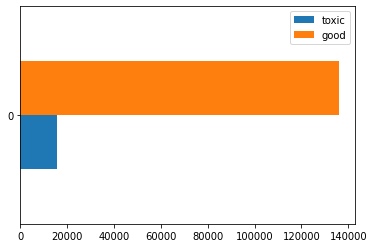

In [8]:
train_toxic = train_df[train_df[classes].sum(axis=1) > 0]
train_clean = train_df[train_df[classes].sum(axis=1) == 0]

pd.DataFrame(dict(
  toxic=[len(train_toxic)], 
  good=[len(train_clean)]
)).plot(kind='barh');

In [9]:
# Undersampling good comments
train_df = pd.concat([
  train_toxic,
  train_clean.sample(15_000)
])

train_df.shape, val_df.shape

((30427, 8), (7979, 8))

# **Pre-processing**

In [10]:
BERT_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

In [11]:
token_counts = []

for _, row in train_df.iterrows():
  token_count = len(tokenizer.encode(
    row["comment_text"], 
    truncation=True
  ))
  token_counts.append(token_count)

In [12]:
print(f'lengthiest comment\'s size: {max(token_counts)}')

lengthiest comment's size: 512


In [13]:
MAX_LENGTH=max(token_counts)

# **Dataset class**

In [14]:
# Built upon Dataset module that tokenizes data and returns
class ToxicCommentsDataset(Dataset):

  def __init__(self, data: pd.DataFrame, tokenizer: BertTokenizer, max_token_len: int = 512):
    self.tokenizer = tokenizer
    self.data = data
    self.max_token_len = max_token_len
    
  def __len__(self):
    return len(self.data)

  def __getitem__(self, index: int):
    data_row = self.data.iloc[index]

    comment_text = data_row.comment_text
    labels = data_row[TARGET_CLASSES]

    encoding = self.tokenizer.encode_plus(
      comment_text,
      add_special_tokens=True,
      max_length=self.max_token_len,
      return_token_type_ids=False,
      padding="max_length",
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return dict(
      comment_text=comment_text,
      input_ids=encoding["input_ids"].flatten(),
      attention_mask=encoding["attention_mask"].flatten(),
      labels=torch.FloatTensor(labels)
    )

In [15]:
# Load the dataset using dataset loader
train_dataset = ToxicCommentsDataset(
  train_df,
  tokenizer,
  max_token_len=MAX_LENGTH
)

# sample_item = train_dataset[0]
# sample_item.keys()

In [16]:
sample_batch = next(iter(DataLoader(train_dataset, batch_size=8, num_workers=2)))
sample_batch["input_ids"].shape, sample_batch["attention_mask"].shape

(torch.Size([8, 512]), torch.Size([8, 512]))

In [17]:
# Data module using Lightning data module

class ToxicCommentDataModule(pl.LightningDataModule):

  def __init__(self, train_df, test_df, tokenizer, batch_size=8, max_token_len=128):
    super().__init__()
    self.batch_size = batch_size
    self.train_df = train_df
    self.test_df = test_df
    self.tokenizer = tokenizer
    self.max_token_len = max_token_len

  def setup(self, stage=None):
    self.train_dataset = ToxicCommentsDataset(
      self.train_df,
      self.tokenizer,
      self.max_token_len
    )

    self.test_dataset = ToxicCommentsDataset(
      self.test_df,
      self.tokenizer,
      self.max_token_len
    )

  def train_dataloader(self):
    return DataLoader(
      self.train_dataset,
      batch_size=self.batch_size,
      shuffle=True,
      num_workers=2
    )

  def val_dataloader(self):
    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size,
      num_workers=2
    )

  def test_dataloader(self):
    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size,
      num_workers=2
    )

In [18]:
N_EPOCHS = 10
BATCH_SIZE = 12

# All data loading logic
data_module = ToxicCommentDataModule(
  train_df,
  val_df,
  tokenizer,
  batch_size=BATCH_SIZE,
  max_token_len=MAX_LENGTH
)

# **The BERT model**

In [19]:
# bert_model = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
# bert_model

In [46]:
# Custom model bert + a layer to classify - using lightning module

class ToxicCommentTagger(pl.LightningModule):

  def __init__(self, n_classes: int, n_training_steps=None, n_warmup_steps=None,learning_rate=1e-5):
    super().__init__()
    self.bert = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
    self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.n_training_steps = n_training_steps
    self.n_warmup_steps = n_warmup_steps
    self.learning_rate=learning_rate
    self.criterion = nn.BCELoss()

  def forward(self, input_ids, attention_mask, labels=None):
    output = self.bert(input_ids, attention_mask=attention_mask)
    output = self.classifier(output.pooler_output)
    output = torch.sigmoid(output)    
    loss = 0
    if labels is not None:
        loss = self.criterion(output, labels)
    return loss, output

  def training_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("train_loss", loss, prog_bar=True, logger=True)
    return {"loss": loss, "predictions": outputs, "labels": labels}

  def validation_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("val_loss", loss, prog_bar=True, logger=True)
    return loss

  def test_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("test_loss", loss, prog_bar=True, logger=True)
    return loss

  def training_epoch_end(self, outputs):
    
    labels = []
    predictions = []
    for output in outputs:
      for out_labels in output["labels"].detach().cpu():
        labels.append(out_labels)
      for out_predictions in output["predictions"].detach().cpu():
        predictions.append(out_predictions)

    labels = torch.stack(labels).int()
    predictions = torch.stack(predictions)

    self.log('train_acc_epoch', accuracy(predictions, labels, threshold=0.5).item(),prog_bar=True, logger=True)

  def configure_optimizers(self):

    optimizer = AdamW(self.parameters(), lr=self.learning_rate)

    scheduler = get_linear_schedule_with_warmup(
      optimizer,
      num_warmup_steps=self.n_warmup_steps,
      num_training_steps=self.n_training_steps
    )

    return dict(
      optimizer=optimizer,
      lr_scheduler=dict(
        scheduler=scheduler,
        interval='step'
      )
    )

In [21]:
steps_per_epoch=len(train_df) // BATCH_SIZE
total_training_steps = steps_per_epoch * N_EPOCHS
warmup_steps = total_training_steps // 5
warmup_steps, total_training_steps

(5070, 25350)

In [22]:
model = ToxicCommentTagger(
  n_classes=len(TARGET_CLASSES),
  n_warmup_steps=warmup_steps,
  n_training_steps=total_training_steps,
  learning_rate=2e-5 
)

# **Training**

In [23]:
checkpoint_callback = ModelCheckpoint(
  dirpath="checkpoints",
  filename="best-checkpoint",
  save_top_k=1,
  verbose=True,
  monitor="val_loss",
  mode="min"
)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: Checkpoint directory checkpoints exists and is not empty.
  warnings.warn(*args, **kwargs)


In [24]:
# Using wandb logger
wandb_logger = WandbLogger(project="toxic-comments")

In [25]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=2)

In [26]:
trainer = pl.Trainer(
  logger=wandb_logger,
  checkpoint_callback=checkpoint_callback,
  callbacks=[early_stopping_callback],
  max_epochs=N_EPOCHS,
  gpus=1,
  progress_bar_refresh_rate=30
)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores


In [ ]:
# Uncomment to re-train the model
# trainer.fit(model, data_module)

In [32]:
# Loading the saved model
trained_model = ToxicCommentTagger.load_from_checkpoint(
  # trainer.checkpoint_callback.best_model_path, 
  'checkpoints/best-checkpoint.ckpt', # using saved model
  n_classes=len(TARGET_CLASSES)
)
trained_model.eval()
trained_model.freeze()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_model = trained_model.to(device)

In [36]:
THRESHOLD = 0.5

test_comment = "You are such a bitch!!"
encoding = tokenizer.encode_plus(
  test_comment,
  add_special_tokens=True,
  max_length=512,
  return_token_type_ids=False,
  padding="max_length",
  return_attention_mask=True,
  return_tensors='pt',
)

_, test_prediction = trained_model(encoding["input_ids"].to(device), encoding["attention_mask"].to(device))
test_prediction = test_prediction.flatten().cpu().data.numpy()

for label, prediction in zip(TARGET_CLASSES, test_prediction):
  if prediction < THRESHOLD:
    continue
  print(f"{label}: {prediction}")

toxic: 0.9972378015518188
obscene: 0.989346444606781
insult: 0.9757869243621826


In [37]:
val_dataset = ToxicCommentsDataset(
  val_df,
  tokenizer,
  max_token_len=MAX_LENGTH
)

predictions = []
labels = []

for item in tqdm(val_dataset):
  _, prediction = trained_model(
    item["input_ids"].unsqueeze(dim=0).to(device), 
    item["attention_mask"].unsqueeze(dim=0).to(device)
  )
  predictions.append(prediction.flatten())
  labels.append(item["labels"].int())

predictions = torch.stack(predictions).detach().cpu()
labels = torch.stack(labels).detach().cpu()

  0%|          | 0/7979 [00:00<?, ?it/s]

In [45]:
print(f'accuracy is : {accuracy(predictions, labels, threshold=THRESHOLD).item()}')

accuracy is : 0.982077956199646


In [1]:
def hpoptimize(model):
  def get_accuracy(model):
    val_dataset = ToxicCommentsDataset(
                  val_df,
                  tokenizer,
                  max_token_len=MAX_LENGTH
                )

    predictions = []
    labels = []
    i=0
    for item in tqdm(val_dataset):
      _, prediction = model(
        item["input_ids"].unsqueeze(dim=0), 
        item["attention_mask"].unsqueeze(dim=0)
      )
      predictions.append(prediction.flatten())
      labels.append(item["labels"].int())
      i+=1
      if i==1000:
        break

    predictions = torch.stack(predictions)
    labels = torch.stack(labels)
    return accuracy(predictions, labels, threshold=THRESHOLD).item()

  def objective(trial):
    params={
        'learning_rate':trial.suggest_loguniform("learning_rate",1e-6,1e-3)
    }
    model = ToxicCommentTagger(
      n_classes=len(TARGET_CLASSES),
      n_warmup_steps=len(train_df)*N_EPOCHS//5,
      n_training_steps=len(train_df)*N_EPOCHS,
      learning_rate=params['learning_rate'] 
    )
    trainer.fit(model, data_module)
    return get_accuracy(model)

  study=optuna.create_study(direction='maximize')
  study.optimize(objective,n_trials=10)
  print(f'best trial: {study.best_trial}')
  return ToxicCommentTagger(
      n_classes=len(TARGET_CLASSES),
      n_warmup_steps=len(train_df)*N_EPOCHS//5,
      n_training_steps=len(train_df)*N_EPOCHS,
      learning_rate=study.best_trial.params['learning_rate'] 
    )

  


  

  



In [4]:
# Get the best model after hpoptimization
N_EPOCHS=2
trained_model=hpoptimize(trained_model)


NameError: ignored

In [ ]:
N_EPOCHS=10